In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline

import pingouin as pg
import warnings
warnings.filterwarnings("ignore")

# <font color='red'> Decision Trees </font>

- Decision trees can be used to classify objects into categories, in which case they are called a Classification Trees, or to predict numerical values, when they are referred to as Regression Trees.
- Decision trees can combine numeric data with categorical/boolen data. 
- The very top of the tree is called the ROOT node. The nodes having arrows pointing to and away from them are called BRANCHES. Meanwhile, the nodes which do not have any arrows pointing away are called LEAVES.

## <font color='green'> Classification Trees </font>

- Given some data, how does one decide which decision tree is the best? (i.e. the order of the questions)
- Typically, every leaf will have a certain degree of IMPURITY, meaning that they cannot alone predict the outcome. There are several ways to quantify impurity: Gini impurity, Entropy, Information Gain.


### Gini Impurity

- Gini Impurity is a measurement used to build Decision Trees to determine how the features of a dataset should split nodes to form the tree.
- Suppose we: (1) Randomly pick a datapoint in our dataset, then (2) Randomly classify it according to the class distribution in the dataset.
- The Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset. Given $C$ total classes and $p(i)$ as the probability of picking a datapoint with class $i$, the Gini impurity is calculated as:
$$G = \sum_{i=1}^C p(i) \times (1-p(i))~.$$
- A Gini Impurity of 0 is the lowest and best possible impurity. It can only be achieved when everything is the same class.
- When training a decision tree, the best split is chosen by maximizing the Gini Gain, which is calculated by subtracting the weighted Gini impurities of the branches from the original impurity - this is the amount of impurity that we have removed!
$$Gain = GI_0 - w_i \times {\rm GI}_i~.$$

- What we described above is a method for calculating Gini impurity for non-numerical values. For numerical values, one first sorts these values, and then calculates the Gini impurity of the average. (i.e. decision tree contains question value > avg or not)
- The ROOT of a decision tree will be decided as the Leaf with the LOWEST GINI impurity! One then repeats the algorithm by computing the GINI impurities of the possible new leaves.
- The output of the leaves is generally taken as the majority of the elements in the leaf class. Note that decision trees can lead to very few elements in the output leaves, which typically tend to OVERFIT the data.

## <font color='green'>Regression Trees </font>

- In regression trees, each leaf represents a numeric value.

See: https://www.youtube.com/watch?v=g9c66TUylZ4, or https://medium.com/analytics-vidhya/regression-trees-decision-tree-for-regression-machine-learning-e4d7525d8047. 

- Consider the following dataset:

In [61]:
data = {'X': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
        'Y': [1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1]}
df = pd.DataFrame(data)

<Axes: xlabel='X', ylabel='Y'>

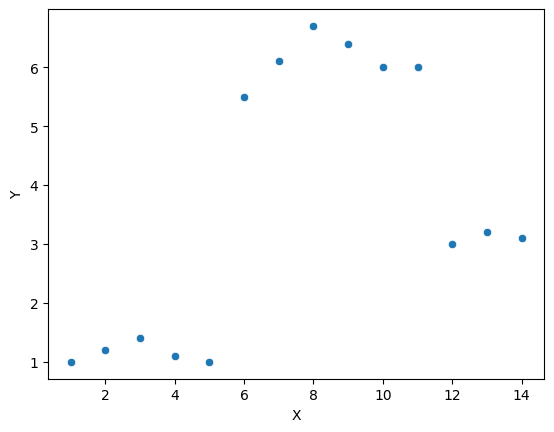

In [7]:
sns.scatterplot(x = df['X'], y = df['Y'])

- Given this data, how can one best predict the variable $Y$, given $X$? It is clear that a simple linear regression won't work, so we need something else. 
- The answer is a REGRESSION TREE! How does this work?
- Step 1: sort the data based on $X$. Then, take the average of the first 2 rows in $X$ (=1.5 here) and divide dataset in 2 parts depending on whether $X<1.5$ or $X \geq 1.5$. The predicted values will be the AVERAGE of all values in the two categories. Given these predicted values, compute the MEAN SQUARE ERROR (or Sum of Squared Residuals SSR/RSS):
$${\rm MSE} = \frac{1}{n} \sum_i^n \left( Y_i - \hat{Y}_i\right)^2~.$$
- Step 2: Repeat above process for all consecutive pairs of $X$ values and compute the MSE.
- Step 3: Choose ROOT note for the tree by picking smallest MSE!

For our data, we get the following MSEs:

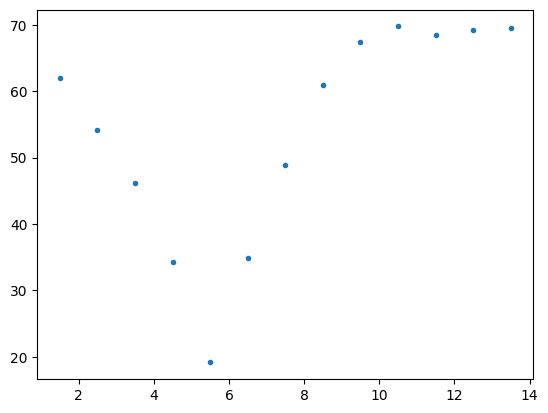

In [41]:
Xavg = []
MSE = []
N = len(df['X'])
 
for i in range(1, N):
    Xavg += [(df['X'][i-1] + df['X'][i])/2]
    rss = 0
    Yl, Yh = sum(df['Y'][:i])/i, sum(df['Y'][i:])/(N-i)
    MSE += [sum((df['Y'][:i] - Yl)**2) + sum((df['Y'][i:] - Yh)**2)] 

plt.plot(Xavg, MSE, '.')

- So for our particular tree, we should use X<5.5 as the ROOT node! This will automatically give a pure leaf!
- What happens when there are multiple independent variables? Then, at each node, all the variables would go through the same process as what X went through in the above example. The data would be sorted based on the $n$ variables separately. The points that minimises the mse are calculated for all the $n$ variables. Out of the $n$ variables and the points calculated for them, the one that has the least mse would be chosen.
- What if there are Categorical variables? If there is a binary choice (e.g. true/false), there is only one possible leaf (as for categorical trees), giving thus one MSE, which is to be compared with the other values.

[Text(0.4, 0.8333333333333334, 'x[0] <= 5.5\nsquared_error = 4.989\nsamples = 14\nvalue = 3.693'),
 Text(0.2, 0.5, 'squared_error = 0.022\nsamples = 5\nvalue = 1.14'),
 Text(0.6, 0.5, 'x[0] <= 11.5\nsquared_error = 2.117\nsamples = 9\nvalue = 5.111'),
 Text(0.4, 0.16666666666666666, 'squared_error = 0.138\nsamples = 6\nvalue = 6.117'),
 Text(0.8, 0.16666666666666666, 'squared_error = 0.007\nsamples = 3\nvalue = 3.1')]

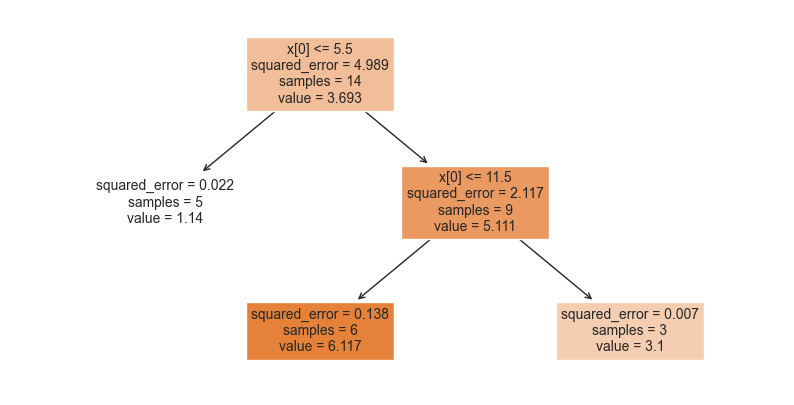

In [63]:
from sklearn import tree

X, y = df['X'].values.reshape(-1, 1), df['Y'].values.reshape(-1, 1)
reg = tree.DecisionTreeRegressor(max_depth=2, min_samples_split=6).fit(X,y)

plt.figure(figsize=(10,5))
tree.plot_tree(reg, filled=True, fontsize=10)

- Note that in this example we set MANUALLY the values max_depth=2 and min_samples_split=6, to avoid overfitting. Let us discuss this next! Before that, let us look at the residuals:

In [76]:
len(residual)

14

Text(0.5, 0, 'Quantiles')

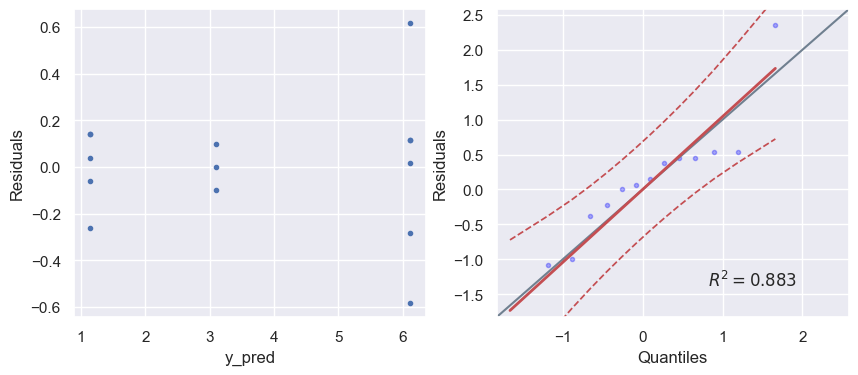

In [81]:
y_pred = reg.predict(X)
residual = y_pred - y.T[0]


fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(y_pred, residual, marker='.')
pg.qqplot(residual, dist='norm', confidence=.95, marker=".", ax=axes[1], square=False, alpha=0.3)

axes[0].set_ylabel('Residuals')
axes[0].set_xlabel('y_pred')

axes[1].set_ylabel('Residuals')
axes[1].set_xlabel('Quantiles')

## <font color='green'>Overfitting - Pruning </font>

- How do we avoid overfitting data? One way is to put limits on how trees grow - i.e. we require a certain number of elements to reach each leaf! This number is chosen with CROSS VALIDATION.
- Another way is PRUNING, which we discuss in more detail momentarily. First, let us see how we can change some tree parameters on a DecisionTreeClassifier.

#### A first example

See: https://towardsdatascience.com/how-to-prune-decision-trees-to-make-the-most-out-of-them-3733bd425072

https://www.youtube.com/watch?v=D0efHEJsfHo

In [60]:
from sklearn import tree
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True)

- The wine dataset has 178 observations, that belong to 3 different classes. There are 13 features that describe the observations.

In [61]:
print(X.shape)
np.unique(y, return_counts=True)

(178, 13)


(array([0, 1, 2]), array([59, 71, 48], dtype=int64))

[Text(0.5, 0.8333333333333334, 'x[12] <= 755.0\ngini = 0.658\nsamples = 178\nvalue = [59, 71, 48]'),
 Text(0.25, 0.5, 'x[11] <= 2.115\ngini = 0.492\nsamples = 111\nvalue = [2, 67, 42]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.227\nsamples = 46\nvalue = [0, 6, 40]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.117\nsamples = 65\nvalue = [2, 61, 2]'),
 Text(0.75, 0.5, 'x[6] <= 2.165\ngini = 0.265\nsamples = 67\nvalue = [57, 4, 6]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.375\nsamples = 8\nvalue = [0, 2, 6]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.065\nsamples = 59\nvalue = [57, 2, 0]')]

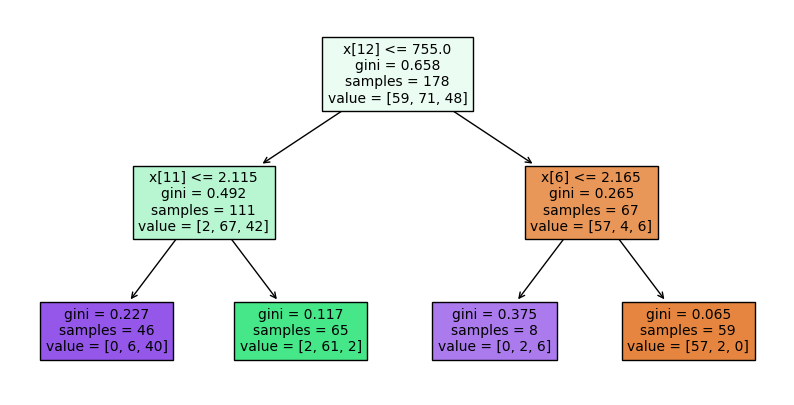

In [62]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=2).fit(X,y)

plt.figure(figsize=(10,5))
tree.plot_tree(clf, filled=True, fontsize=10)

- The partitions are selected based on Gini impurity and the depth of the tree is 2. Max_depth provides a simple way to control tree growth which may not be enough in more complex cases.
- The min_samples_split specifies the minimum number of samples in a node to be further split - Nodes with min_samples_split <= value, can no longer be split!
- Another hyperparameter to control tree growth is min_impurity_decrease which sets a threshold on the impurity decrease to consider a partition. It is a more educated way than the max depth because it takes into account the quality of a partition. When setting this value, we should also consider the criterion because Gini impurity and Entropy have different values!
- The max_leaf_nodes can also be used to control tree growth. It limits the number of leaf nodes a decision tree can have. The leaf nodes are the nodes at the end of a decision tree.

[Text(0.6, 0.8333333333333334, 'x[12] <= 755.0\ngini = 0.658\nsamples = 178\nvalue = [59, 71, 48]'),
 Text(0.4, 0.5, 'x[11] <= 2.115\ngini = 0.492\nsamples = 111\nvalue = [2, 67, 42]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.227\nsamples = 46\nvalue = [0, 6, 40]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.117\nsamples = 65\nvalue = [2, 61, 2]'),
 Text(0.8, 0.5, 'gini = 0.265\nsamples = 67\nvalue = [57, 4, 6]')]

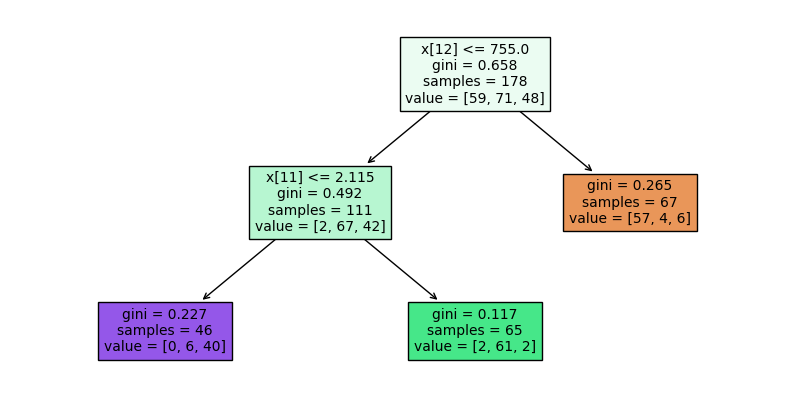

In [64]:
clf = tree.DecisionTreeClassifier(criterion='gini', min_impurity_decrease=0.1).fit(X, y)
plt.figure(figsize=(10, 5))
tree.plot_tree(clf, filled=True, fontsize=10)

### Cost Complexity Pruning (Weakest Tree Pruning)

- Pruning is a data compression technique in machine learning and search algorithms that reduces the size of decision trees by removing sections of the tree that are non-critical and redundant to classify instances. Pruning reduces the complexity of the final classifier, and hence improves predictive accuracy by the reduction of overfitting.
- How do we decide which tree to use? In cost complexity pruning, one computes the RSS for the original (potentially over-fitted) tree as the SUM of the RSS for each leaf. Then, one reduces the tree by eliminating leaves and computes the new RSSs. Naturally, the RSS for the training data will increase by removing leaves.
- For Decision Tree Regressors, Weakest Tree Pruning works by assigning a TREE SCORE to each tree of the form:
$$\text{Tree Score} = {\rm RSS} + \alpha T~,$$
where $T$ is the number of Terminal nodes in the tree. The Tree complexity penalty compensates for the difference in the number of leaves. The tuning parameter $\alpha \geq 0$ is determined using cross-validation.

IDEA: THE MORE LEAVES, THE LARGER THE PENALTY!


- So how do we find $\alpha$ in practice? First, build a decision tree using the WHOLE data and compute the RSS. This tree has the best (lowest) tree score for $\alpha = 0$. Now, as $\alpha$ is increased, it will eventually be the case that a tree with less leaves will have a lower tree score. We record this value of $\alpha$ and associate it with the new reduced tree. We keep increasing $\alpha$ until we get to a tree with only the ROOT node.
- So far, we have a list of trees, each corresponding to a treshold $\alpha$ value. The next step is to divide the data in TRAIN and TEST sets. Just using TRAINING data, use the discrete values of $\alpha$ that we found before to build a sequence of new trees which minimize the Tree score.
- Finally, calculate the RSS for each new tree using ONLY the TESTING data! Repeat this process until we have done 10-fold Cross Validation. The value of $\alpha$ giving, on average, the lowest RSS, is the optimal value!

#### Cost Complexity Pruning on DecisionTreeRegressor

<Axes: xlabel='X', ylabel='Y'>

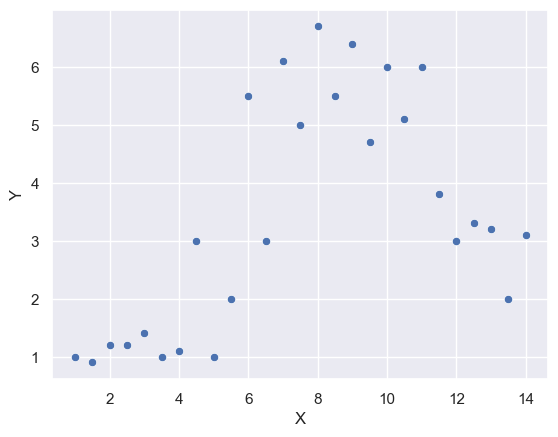

In [82]:
# Let us add more data to previous Regression data 
data = {'X': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5], 
        'Y': [1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1, 0.9, 1.2, 1,3, 2, 3, 5, 5.5, 4.7, 5.1, 3.8, 3.3, 2]}
df = pd.DataFrame(data)
sns.scatterplot(x = df['X'], y = df['Y'])

- Using a DecisionTreeRegressor on the data, we find the following:

[Text(0.5595238095238095, 0.9, 'x[0] <= 5.75\nsquared_error = 3.575\nsamples = 13\nvalue = 2.7'),
 Text(0.30952380952380953, 0.7, 'x[0] <= 4.25\nsquared_error = 0.457\nsamples = 8\nvalue = 1.425'),
 Text(0.19047619047619047, 0.5, 'x[0] <= 1.75\nsquared_error = 0.014\nsamples = 5\nvalue = 1.08'),
 Text(0.09523809523809523, 0.3, 'x[0] <= 1.25\nsquared_error = 0.003\nsamples = 2\nvalue = 0.95'),
 Text(0.047619047619047616, 0.1, 'squared_error = 0.0\nsamples = 1\nvalue = 1.0'),
 Text(0.14285714285714285, 0.1, 'squared_error = 0.0\nsamples = 1\nvalue = 0.9'),
 Text(0.2857142857142857, 0.3, 'x[0] <= 3.25\nsquared_error = 0.002\nsamples = 3\nvalue = 1.167'),
 Text(0.23809523809523808, 0.1, 'squared_error = 0.0\nsamples = 2\nvalue = 1.2'),
 Text(0.3333333333333333, 0.1, 'squared_error = -0.0\nsamples = 1\nvalue = 1.1'),
 Text(0.42857142857142855, 0.5, 'x[0] <= 4.75\nsquared_error = 0.667\nsamples = 3\nvalue = 2.0'),
 Text(0.38095238095238093, 0.3, 'squared_error = 0.0\nsamples = 1\nvalue = 3.0

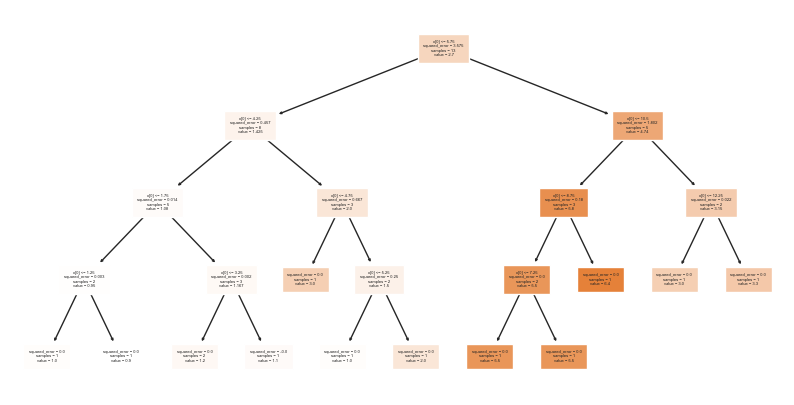

In [44]:
X, y = df['X'].values.reshape(-1, 1), df['Y'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.50, random_state=45)

reg = tree.DecisionTreeRegressor().fit(X_train,y_train)

plt.figure(figsize=(10,5))
tree.plot_tree(reg, filled=True, fontsize=3)

In [46]:
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)


RSS_train = sum((y_train_pred - y_train.T[0])**2)
RSS_test = sum((y_test_pred - y_test.T[0])**2)
print('R^2 scores in training and testing:', reg.score(X_train, y_train), reg.score(X_test, y_test))
print('RSS in training and testing:', RSS_train, RSS_test)

R^2 scores in training and testing: 1.0 0.45089679270384186
RSS in training and testing: 0.0 24.470000000000002


- So the model clearly OVERFITS the training data! Hence, let us use CostComplexityPruning. First, we fit the tree with the whole data, to get a set of alphas. 

In [47]:
path = reg.cost_complexity_pruning_path(X, y)
alphas = path['ccp_alphas']
alphas

array([0.00000000e+00, 1.85185185e-04, 1.85185185e-04, 1.85185185e-04,
       9.87654321e-04, 1.54320988e-03, 2.08641975e-03, 2.79894180e-03,
       1.00000000e-02, 1.11419753e-02, 1.44444444e-02, 1.85185185e-02,
       2.05925926e-02, 2.24074074e-02, 2.37695473e-02, 2.96604938e-02,
       5.55555556e-02, 6.10158730e-02, 1.15740741e-01, 1.31359895e-01,
       8.19890407e-01, 2.43557137e+00])

- Now, note that we do not have a large dataset, so it is perhaps not the best approach to use k-fold cross-validation. For instance, for $k = 2$, we already get $R^2$ scores of 0.4 or lower. Lowering $k$, we even get negative coefficients of determination!!

In [51]:
mean, std = [], []

for a in alphas:
    reg = tree.DecisionTreeRegressor(ccp_alpha=a, random_state=0)

    # 2 fold cross validation for each alpha value
    scores = cross_val_score(reg, X, y, cv=2) # uses the .score of the DecisionTree 
    mean.append(scores.mean())
    std.append(scores.std())
    
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies
eva_df = pd.DataFrame({'alpha': alphas, 'mean': mean, 'std': std})
eva_df = eva_df.sort_values(['mean'], ascending = False)
eva_df

,alpha,mean,std
17,0.061016,0.394447,0.190441
16,0.055556,0.394447,0.190441
8,0.010000,0.393110,0.120195
9,0.011142,0.393110,0.120195
11,0.018519,0.386812,0.126493
14,0.023770,0.386812,0.126493
10,0.014444,0.386812,0.126493
15,0.029660,0.386812,0.126493
12,0.020593,0.386812,0.126493
13,0.022407,0.386812,0.126493


- So let us just use 1 training/testing set.

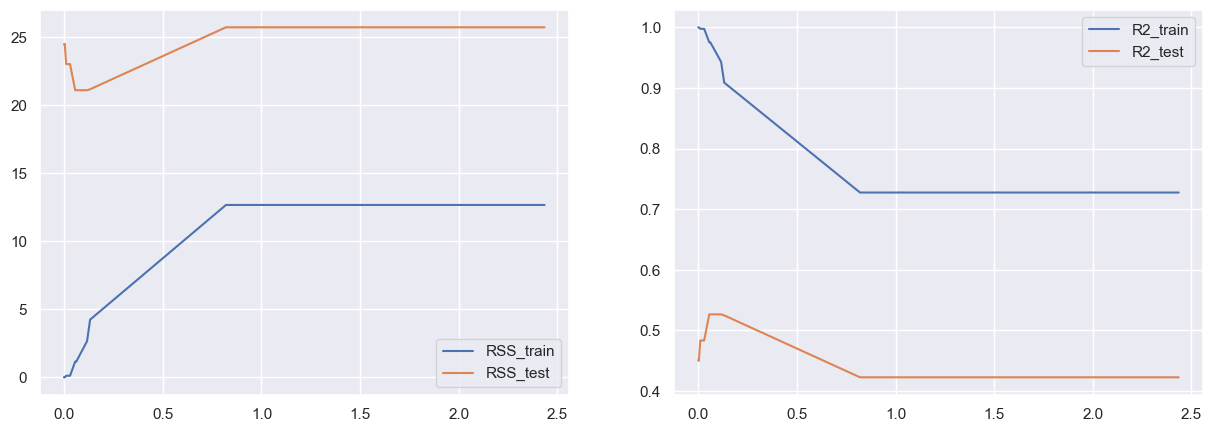

In [53]:
RSS_train, RSS_test = [], []
R2_train, R2_test = [], []


for a in alphas:
    clf = tree.DecisionTreeRegressor(ccp_alpha = a).fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    RSS_train.append(sum((y_train_pred - y_train.T[0])**2))
    RSS_test.append(sum((y_test_pred - y_test.T[0])**2))
    R2_train.append(clf.score(X_train, y_train))
    R2_test.append(clf.score(X_test, y_test))
    
sns.set()
# plt.figure(figsize=(14,7))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x=alphas, y=RSS_train, label='RSS_train', ax = axes[0])
sns.lineplot(x=alphas, y=RSS_test, label='RSS_test', ax = axes[0])
sns.lineplot(x=alphas, y=R2_train, label='R2_train', ax = axes[1])
sns.lineplot(x=alphas, y=R2_test, label='R2_test', ax = axes[1])
plt.show()

- We find, that in both cases, the error is minimised and R2 maximized for: $\alpha = 0.061016$

In [58]:
[5.55555556e-02, 6.10158730e-02, 1.15740741e-01]

[0.0555555556, 0.061015873, 0.115740741]

In [83]:
X, y = df['X'].values.reshape(-1, 1), df['Y'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.50, random_state=45)

reg = tree.DecisionTreeRegressor(ccp_alpha = 0.061015873).fit(X_train,y_train)
y_test_pred = reg.predict(X_test)

reg.score(X_test, y_test)

0.5264899261087692

Text(0.5, 0, 'Quantiles')

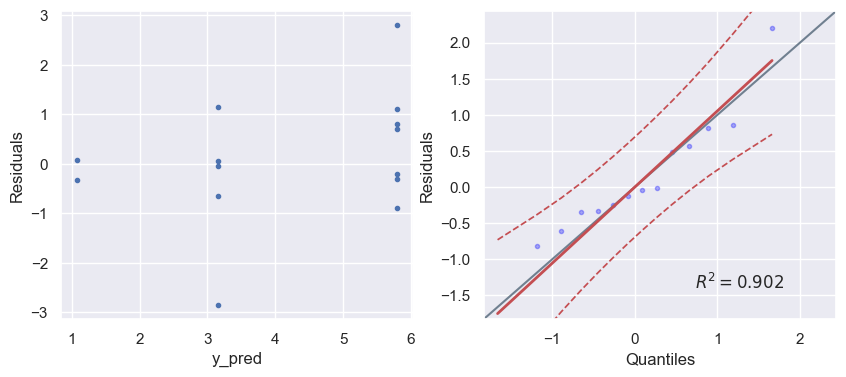

In [85]:
residual = y_test_pred - y_test.T[0]

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(y_test_pred, residual, marker='.')
pg.qqplot(residual, dist='norm', confidence=.95, marker=".", ax=axes[1], square=False, alpha=0.3)

axes[0].set_ylabel('Residuals')
axes[0].set_xlabel('y_pred')

axes[1].set_ylabel('Residuals')
axes[1].set_xlabel('Quantiles')

#### Cost Complexity Pruning on DecisionTreeClassifier 

In [59]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=45)

[Text(0.5, 0.9, 'x[12] <= 755.0\ngini = 0.648\nsamples = 142\nvalue = [51, 59, 32]'),
 Text(0.25, 0.7, 'x[6] <= 1.315\ngini = 0.472\nsamples = 85\nvalue = [2, 55, 28]'),
 Text(0.125, 0.5, 'x[9] <= 3.625\ngini = 0.257\nsamples = 33\nvalue = [0, 5, 28]'),
 Text(0.0625, 0.3, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]'),
 Text(0.1875, 0.3, 'gini = 0.0\nsamples = 28\nvalue = [0, 0, 28]'),
 Text(0.375, 0.5, 'x[0] <= 13.175\ngini = 0.074\nsamples = 52\nvalue = [2, 50, 0]'),
 Text(0.3125, 0.3, 'gini = 0.0\nsamples = 48\nvalue = [0, 48, 0]'),
 Text(0.4375, 0.3, 'x[4] <= 95.0\ngini = 0.5\nsamples = 4\nvalue = [2, 2, 0]'),
 Text(0.375, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(0.5, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]'),
 Text(0.75, 0.7, 'x[6] <= 2.165\ngini = 0.251\nsamples = 57\nvalue = [49, 4, 4]'),
 Text(0.625, 0.5, 'x[1] <= 2.085\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.5625, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(0.6875, 0.3, '

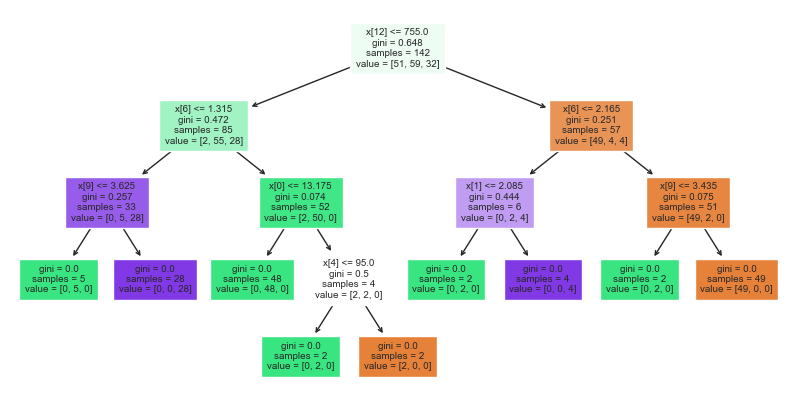

In [90]:
clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

plt.figure(figsize=(10, 5))
tree.plot_tree(clf, filled=True, fontsize=7)

- We get a model that has RSS = 4 in testing (but RSS = 0 for training). Is this a good model?? Can we do better?

In [91]:
#RSS = sum((y_test_pred - y_test)**2)
print(clf.score(X_test, y_test))#, RSS)

0.9166666666666666 6


In [92]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
alphas = path['ccp_alphas']
alphas

array([0.        , 0.0135428 , 0.01877934, 0.02706435, 0.05497173,
       0.05975245, 0.1958463 , 0.26409   ])

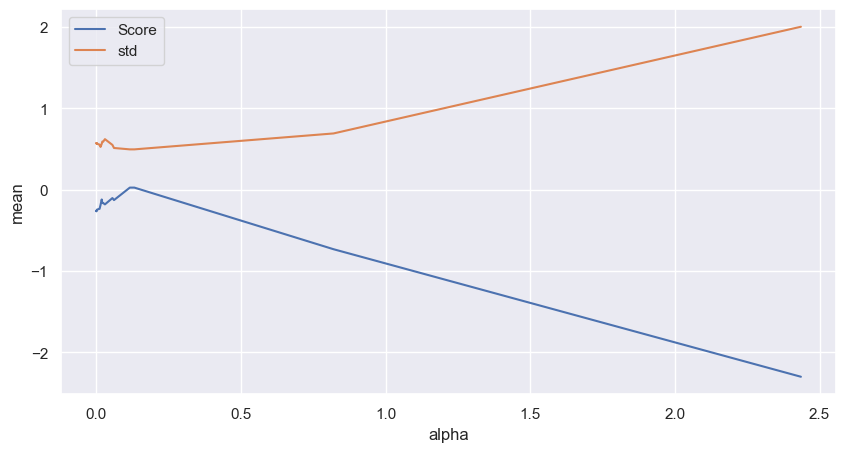

In [38]:
# RSS_train, RSS_test = [], []
R2_train, R2_test = [], []


for a in alphas:
    clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    #RSS_train.append(sum((y_train_pred - y_train)**2))
    #RSS_test.append(sum((y_test_pred - y_test)**2))
    R2_train.append(clf.score(X_train, y_train))
    R2_test.append(clf.score(X_test, y_test))
    
sns.set()
# plt.figure(figsize=(14,7))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x=alphas, y=RSS_train, label='RSS_train', ax = axes[0])
sns.lineplot(x=alphas, y=RSS_test, label='RSS_test', ax = axes[0])
sns.lineplot(x=alphas, y=R2_train, label='R2_train', ax = axes[1])
sns.lineplot(x=alphas, y=R2_test, label='R2_test', ax = axes[1])
plt.show()

- Ok, how do we do cross-validation now? First, calculate the $\alpha$'s for the entire data

In [95]:
clf = tree.DecisionTreeClassifier().fit(X, y)
y_pred = clf.predict(X)

# RSS = sum((y_pred - y)**2)
print(clf.score(X, y)) # , RSS)

path = clf.cost_complexity_pruning_path(X_train, y_train)
alphas = path['ccp_alphas']
alphas

1.0 0


array([0.        , 0.0135428 , 0.01877934, 0.02706435, 0.05497173,
       0.05975245, 0.1958463 , 0.26409   ])

In [106]:
from sklearn.model_selection import cross_val_score

mean, std = [], []

for a in alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=a, random_state=0)

    # 10 fold cross validation for each alpha value
    scores = cross_val_score(clf, X, y, cv=10) # uses the .score of the DecisionTree 
    mean.append(scores.mean())
    std.append(scores.std())
    
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies
eva_df = pd.DataFrame({'alpha': alphas, 'mean': mean, 'std': std})
eva_df = eva_df.sort_values(['mean'], ascending = False)
eva_df


,alpha,mean,std
1,0.013543,0.894118,0.080118
2,0.018779,0.877451,0.088649
3,0.027064,0.877451,0.088649
0,0.000000,0.870588,0.080118
4,0.054972,0.821242,0.094727
5,0.059752,0.815686,0.095481
6,0.195846,0.776797,0.107138
7,0.264090,0.460458,0.125138


- We find the best value to be $\alpha = 0.013543$.

[Text(0.4583333333333333, 0.875, 'x[12] <= 755.0\ngini = 0.648\nsamples = 142\nvalue = [51, 59, 32]'),
 Text(0.25, 0.625, 'x[6] <= 1.315\ngini = 0.472\nsamples = 85\nvalue = [2, 55, 28]'),
 Text(0.16666666666666666, 0.375, 'x[9] <= 3.625\ngini = 0.257\nsamples = 33\nvalue = [0, 5, 28]'),
 Text(0.08333333333333333, 0.125, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]'),
 Text(0.25, 0.125, 'gini = 0.0\nsamples = 28\nvalue = [0, 0, 28]'),
 Text(0.3333333333333333, 0.375, 'gini = 0.074\nsamples = 52\nvalue = [2, 50, 0]'),
 Text(0.6666666666666666, 0.625, 'x[6] <= 2.165\ngini = 0.251\nsamples = 57\nvalue = [49, 4, 4]'),
 Text(0.5, 0.375, 'x[6] <= 0.855\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.4166666666666667, 0.125, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 4]'),
 Text(0.5833333333333334, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(0.8333333333333334, 0.375, 'x[9] <= 3.435\ngini = 0.075\nsamples = 51\nvalue = [49, 2, 0]'),
 Text(0.75, 0.125, 'gini = 0.0\nsample

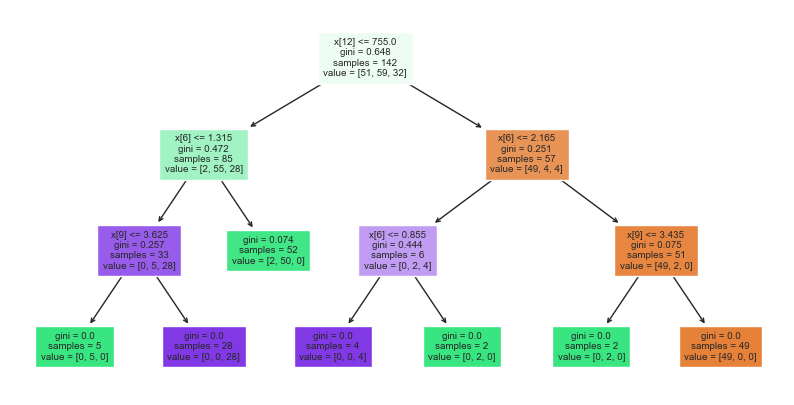

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=45)

# fit the pruned tree
prunedtree = tree.DecisionTreeClassifier(ccp_alpha=eva_df['alpha'][1], random_state=0).fit(X_train, y_train)
plt.figure(figsize=(10, 5))
tree.plot_tree(prunedtree, filled=True, fontsize=7)

In [110]:
y_test_pred = prunedtree.predict(X_test)

prunedtree.score(X_test, y_test)

0.9166666666666666

### Parameter Tuning - Grid Search

- We have mentioned before that an alternative to pruning is setting the parameters. We do this using a grid search.
- see https://vzhang1999.medium.com/classification-tree-growing-and-pruning-with-python-code-grid-search-cost-complexity-function-b2e45e33a1a4

In [111]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=45)

### Linear Regressor vs Decision Tree Regressor 

- With decision tree regression, you can be a little more relaxed about assumptions. In particular, you simply give up on the "linearity" (or more precisely, the correct functional specification) assumption, because the natural process obviously does not follow the piecewise flat segmentation that is assumed by the tree model. Instead, you simply acknowledge that the model is wrong with regard to the "linearity" assumption, but proceed anyway, hoping that the flexibility and ease of interpretation of the model overcome this glaringly incorrect assumption.
- The normality and constant variance assumptions have at least two useful aspects as regards to tree regression. (1) The within-node prediction bounds $ \hat{y}\pm 2 {\rm rmse}$ make sense under these conditions; (2) The least squares estimation criteria also makes sense under these conditions. Absent these conditions, alternate estimation procedures and prediction bounds are better. In particular, the DecisionTreeRegressor can be called with a different cost function - if the qq-plot is prone to outliers, for instance, one can use the mean absolute deviation.
- When there are large number of features with less data-sets (with low noise), linear regressions may outperform Decision trees/random forests. In general cases, Decision trees will be having better average accuracy.
- For categorical independent variables, decision trees are better than linear regression.
- Decision trees handles colinearity better than LR.

## <font color='red'>Random Forests</font>

- Random Forests are built from Decision Trees. The latter are easy to use and implement, but, in practice, they lack accuracy. Decision Trees are typically not flexible when it comes to classifying new samples.
- Random Forests combine the simplicity of decision trees with flexibility, resulting in a vast improvement in accuracy!

See: https://www.youtube.com/watch?v=sQ870aTKqiM

#### Building Random Forests

How do we build a Random Forest?

- Step 1: Bootstrap the original dataset. That is, from the original dataset, randomly select samples - note that samples can be repeated.
- Step 2: Create a decision tree using the bootstrapped dataset, but only use a random subset of variables (columns) at each step! We'll come back to this later.
- Step 3: Repeat previous 2 steps, hundreds of times. This results in a wide variety of decision trees. This is a random forest.
- Q: How do we use this forest? Take a new sample, and run it to every decision tree previously created. Then, we check which category is chosen most times.
- Bootstrapping the data and using the aggregate to make a decision is called BAGGING.

How do we know if the Random Forest is any good?

- Recall that for every decision tree we use a bootstrapped dataset, which will most likely not contain all samples from the original dataset. The samples that are not included form the Out-Of-Bag dataset.
- We take the Out-Of-Bag samples for every decision tree and check how the classifier performs. The proportion of Out-Of-Bag samples incorrectly classified is the Random Forest error!

- Now since we know how to estimate the accuracy of the Random Forest, we can go back to the building stages and vary the number of variables used in constructing the decision trees (in step 2 above)!
- Typically, we start be using the square root of the number of variables and try a few settings above and below the value.

#### Missing Data in Random Forests

- Consider a dataset with certain samples missing some data. Random Forests consider 2 types of missing data: 

    1. missing data in the original dataset used to create the random forest. 
    2. missing data in a new sample that you want to categorize.


- The general idea for dealing with missing data of type (1) is to make an initial guess that could be bad, and then gradually refine the guess until it is (hopefully) a good guess: e.g. initial guess can be the most common (or average for numeric values) entry for the column for entries with the same y value.
- To refine these initial guesses, we first determine which samples are similar to the one with missing data. This 'similarity' is determined by building a Random Forest and  on which leaves the samples end up on. This information is encoded in a proximity matrix.
- The proximity matrix is an $n\times n$ matrix, for $n$ the number of samples. If samples $i, j$ end on the same leaf node of a tree, then the proximity matrix records a $+1$ at entries $(i,j)$ and $(j,i)$. The entries are added together for all trees in the forest. Finally, dividing all values by the total number of trees gives the proximity matrix.
- Say that sample $k$ had missing values. Using the initial guesses, we compute the proximity tree and then use the proximity values for sample $k$ (i.e. the $k$th row of the matrix) to make better guesses about the missing data. That is, we do a weighted frequency (or weighted average for numerical values). This process is repeated until it converges (i.e. build new forest, calculate proximity matrix, rechange values)

- 1 - Proximity matrix = distance matrix. Using distance matrix we can draw a heat map to show how the samples are related to each other!

What about missing data of type (2)?

- Assume that the independent variable is categorical, with only 2 categories, Yes/No. Then, given a new sample for which some of the features are missing, we want to predict its y value. 
- The idea here is to make 2 copies of the sample, one having y = Yes, and one with y = No. Then, we use the iterative method described before to make a good guess about the missing values!
- Finally, we run the 2 samples down the trees in the forest and see which of the two is correctly labeled by the Random Forest the most times!

### An Example

Predicting the max temperature for tomorrow in our city using one year of past weather data: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

- We have access to one year of historical max temperatures, the temperatures for the previous two days, and an estimate from a friend who is always claiming to know everything about the weather. This is a supervised, regression machine learning problem. It’s supervised because we have both the features (data for the city) and the targets (temperature) that we want to predict. During training, we give the random forest both the features and targets and it must learn how to map the data to a prediction. Moreover, this is a regression task because the target value is continuous (as opposed to discrete classes in classification). That’s pretty much all the background we need, so let’s start!

Roadmap:
1. State the question and determine required data
2. Acquire the data in an accessible format
3. Identify and correct missing data points/anomalies as required
4. Prepare the data for the machine learning model
5. Establish a baseline model that you aim to exceed
6. Train the model on the training data
7. Make predictions on the test data
8. Compare predictions to the known test set targets and calculate performance metrics
9. If performance is not satisfactory, adjust the model, acquire more data, or try a different modeling technique
10. Interpret model and report results visually and numerically

Description of data:
- year: 2016 for all data points
- month: number for month of the year
- day: number for day of the year
- week: day of the week as a character string
- temp_2: max temperature 2 days prior
- temp_1: max temperature 1 day prior
- average: historical average max temperature
- actual: max temperature measurement
- friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

#### Importing Data and Outliers/Anomalies

In [159]:
features = pd.read_csv('temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [92]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


- We see immediately some missing data 348 vs 366 days. To identify anomalies, look at:

In [94]:
features.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [160]:
# Use datetime for dealing with dates
import datetime

# Get years, months, and days
years = features['year']
months = features['month']
days = features['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

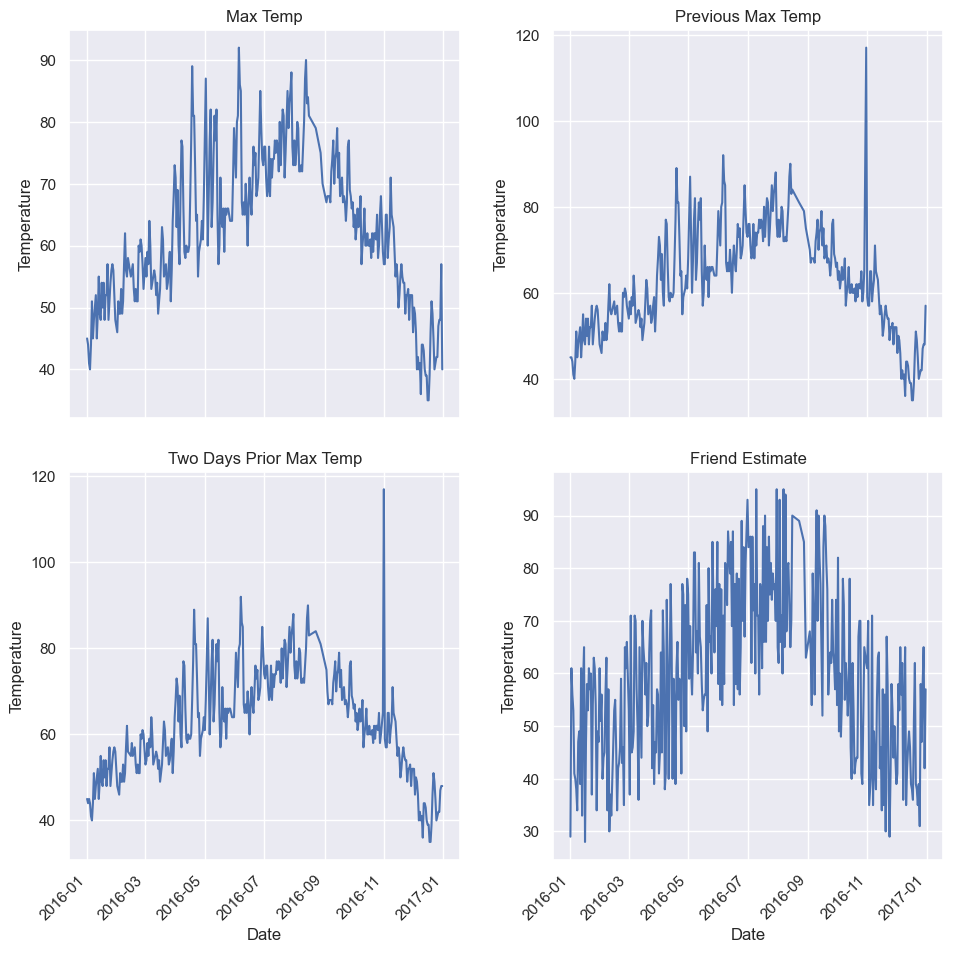

In [161]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45) # rotate x labels

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

- There seems to be a clear outlier in the dataset. We will rewrite these points.

In [141]:
ar = np.append(features['temp_1'][1:].values, np.array([40]))
ar2 = np.append(features['temp_2'][2:].values, np.array([57, 40]))
print(np.where(ar != features['actual'].values))
print(np.where(ar2 != features['actual'].values))

(array([ 56, 285], dtype=int64),)
(array([ 55,  56, 285], dtype=int64),)


In [146]:
features['actual'][285]

68

In [112]:
features[features['temp_1'] == 117]

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
287,2016,11,1,Tues,117,59,54.5,57,51,59,55,61


In [110]:
features[features['temp_2'] == 117]

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
286,2016,10,31,Mon,65,117,54.8,59,51,59,56,62


In [162]:
features['temp_1'][57], features['temp_1'][286] = 53, 68
features['temp_2'][57], features['temp_2'][58], features['temp_2'][287] = 57, 53, 68

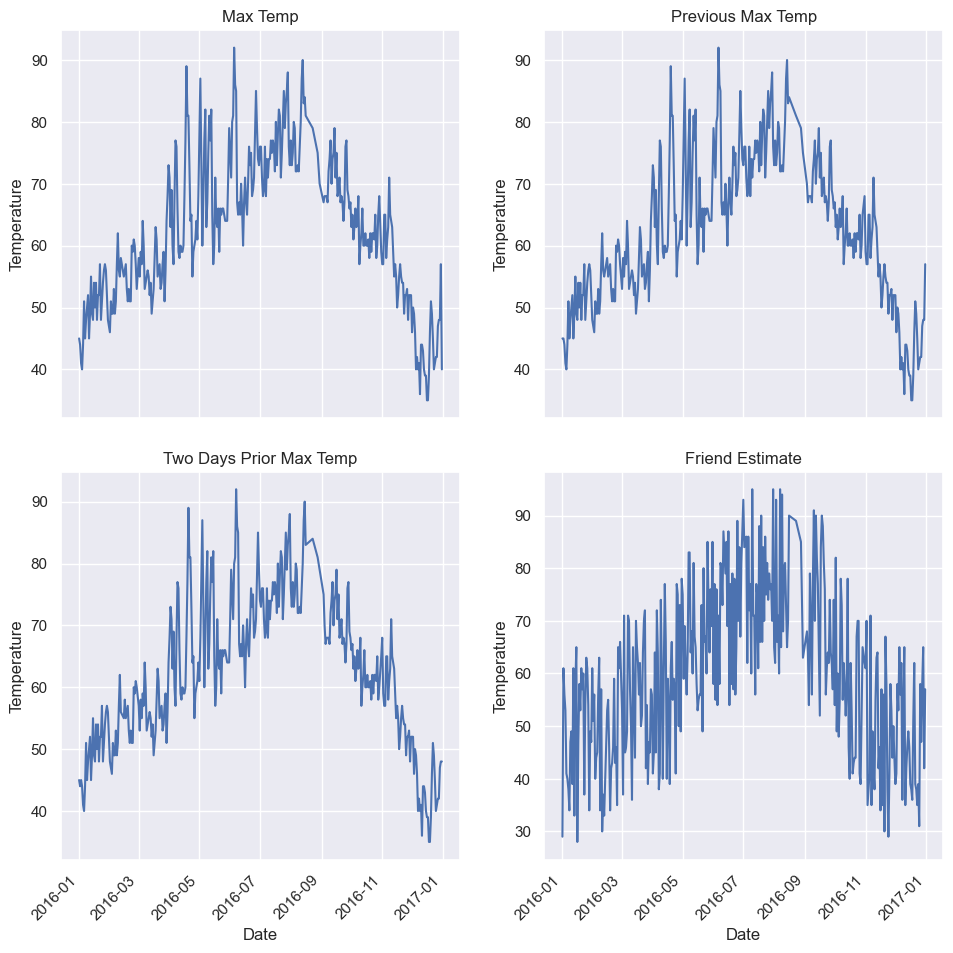

In [148]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45) # rotate x labels

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

#### Feature engineering

- One-Hot encoding: takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering.

In [163]:
features = pd.get_dummies(features)
features.iloc[:,5:].head(5)

,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,46.0,44,46,46,46,41,0,0,0,0,0,1,0


In [211]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   temp_2          348 non-null    int64  
 4   temp_1          348 non-null    int64  
 5   average         348 non-null    float64
 6   forecast_noaa   348 non-null    int64  
 7   forecast_acc    348 non-null    int64  
 8   forecast_under  348 non-null    int64  
 9   friend          348 non-null    int64  
 10  week_Fri        348 non-null    uint8  
 11  week_Mon        348 non-null    uint8  
 12  week_Sat        348 non-null    uint8  
 13  week_Sun        348 non-null    uint8  
 14  week_Thurs      348 non-null    uint8  
 15  week_Tues       348 non-null    uint8  
 16  week_Wed        348 non-null    uint8  
dtypes: float64(1), int64(9), uint8(7)
m

In [164]:
y = np.array(features['actual'])
features = features.drop('actual', axis = 1)
feature_list = list(features.columns)
X = np.array(features)

In [165]:
X.shape

(348, 17)

#### Split dataset

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=45) 

#### Baseline Model

- Before we can make and evaluate predictions, we need to establish a baseline, a sensible measure that we hope to beat with our model. If our model cannot improve upon the baseline, then it will be a failure and we should try a different model or admit that machine learning is not right for our problem. The baseline prediction for our case can be the historical max temperature averages. In other words, our baseline is the error we would get if we simply predicted the average max temperature for all days.


In [185]:
# The baseline predictions are the historical averages
y_baseline_pred = X_test[:, feature_list.index('average')]
# Baseline errors, and display average baseline error
y_baseline_error = abs(y_baseline_pred - y_test)
residual_baseline = y_baseline_pred - y_test
RSS_baseline = sum(residual_baseline**2)
TSS_baseline = sum((y_baseline_pred - np.mean(y_test))**2)
R2_baseline = 1 - (RSS_baseline/TSS_baseline)

print('Average baseline mean absolut error: ', round(np.mean(y_baseline_error), 2))
print('Baseline RSS:', RSS_baseline)
print('Baseline R^2:', R2_baseline)

Average baseline mean absolut error:  3.97
Baseline RSS: 2061.9799999999996
Baseline R^2: 0.733283983431442


#### A first Random Forest Regression

In [186]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [187]:
y_test_pred = rf.predict(X_test)
y_abs_error = abs(y_test_pred - y_test)
residual = y_test_pred - y_test
RSS = sum(residual**2)

print('Mean Absolute Error:', round(np.mean(y_abs_error),2))
print('RSS:', RSS)
print('R^2:', rf.score(X_test, y_test))

Mean Absolute Error: 3.51
RSS: 1480.7049669999997
R^2: 0.8471259833039579


- So we already see an improvement the error and R^2 coefficient!

In [174]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (y_abs_error / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 94.32 %.


In [176]:
# R^2 score
print(rf.score(X_train, y_train),rf.score(X_test, y_test))

0.976261016882244 0.8471259833039579


- Looking at the R2 coefficient, we see a significant drop from training to testing. So it is possible that we overfit the training set.
- Let us look at the residuals. We look for patterns in the residual vs fitted values plot, to see if the RF missed any relationships. 
- Note that a Random Forest Regressor does NOT assume normality of residuals. As the random forest model is an algorithmic modeling approach that imposes no analytic assumption, diagnosis could still be done but interpretations are not as strong as in a linear regression model. There is still value to do so, to find area of improvement of the model.

Text(0.5, 0, 'Quantiles')

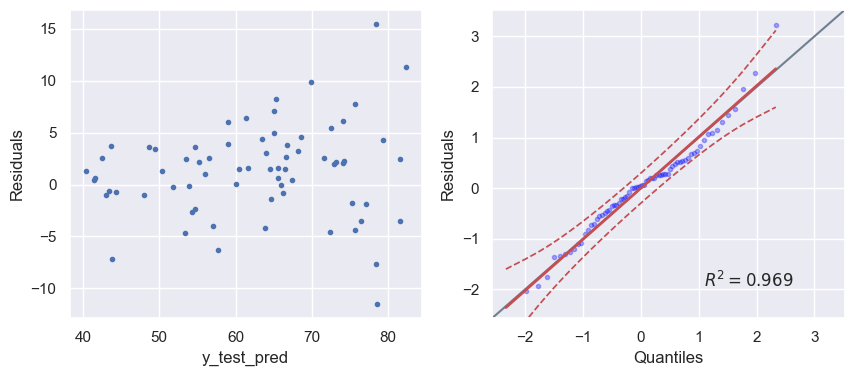

In [191]:
residual = y_test_pred - y_test


fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(y_test_pred, residual, marker='.')
pg.qqplot(residual, dist='norm', confidence=.95, marker=".", ax=axes[1], square=False, alpha=0.3)

axes[0].set_ylabel('Residuals')
axes[0].set_xlabel('y_test_pred')

axes[1].set_ylabel('Residuals')
axes[1].set_xlabel('Quantiles')

#### Variable importance and Visualization

In [193]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.6
Variable: average              Importance: 0.22
Variable: forecast_acc         Importance: 0.06
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: forecast_noaa        Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: forecast_under       Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


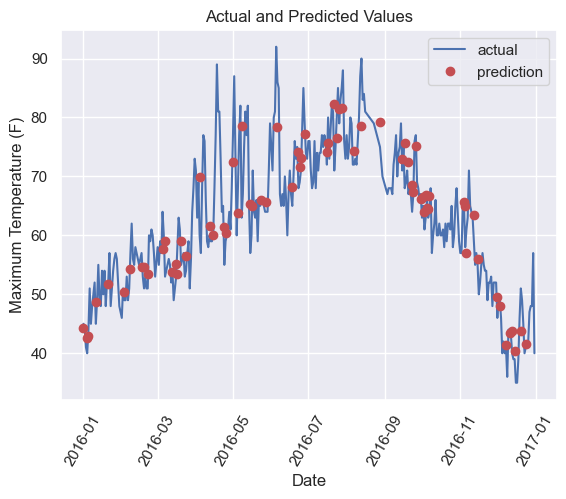

In [197]:
# Use datetime for creating date objects for plotting
import datetime
# Dates of training values
months = X[:, feature_list.index('month')]
days = X[:, feature_list.index('day')]
years = X[:, feature_list.index('year')]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': y})

# Dates of predictions
months = X_test[:, feature_list.index('month')]
days = X_test[:, feature_list.index('day')]
years = X_test[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': y_test_pred})
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = 60); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

#### Improving model

- When using RandomForestRegressor or RandomForestClassifier, the returned fitted model has already been pruned! This happens under the hood in the sklearn implementation. Theoretically speaking too, a RandomForest is not just a combination of DecisionTrees, but is the pruned, aggregated, and using default settings, bootstrapped version of multiple large decision trees.
- Rest assured, the model returned here is not overfitting due to pruning. To avoid over-fitting in random forest, the main thing you need to do is optimize a tuning parameter that governs the number of features that are randomly chosen to grow each tree from the bootstrapped data. Typically, you do this via k-fold cross-validation, where $k \in \{5,10\}$, and choose the tuning parameter that minimizes test sample prediction error. In addition, growing a larger forest will improve predictive accuracy, although there are usually diminishing returns once you get up to several hundreds of trees.
- Note, however, that two of the appealing features of Random Forests are that it is difficult to overfit them and the default parameters are usually fairly good. Let us check the Out-Of-Bag score:

In [201]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(oob_score = True)

# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(oob_score=True)

In [206]:
print(rf.score(X_train, y_train),rf.score(X_test, y_test))
rf.oob_score_

0.9746181711963187 0.8461833201820046


0.8147712777493894

- This is the ccore of the training dataset obtained using an out-of-bag estimate. 
- Let us now try to optimize some parameters of the Random Forest. First, let us look at the bootstrap sample size recorder through max_samples. See also: https://machinelearningmastery.com/random-forest-ensemble-in-python/

In [210]:
vals = np.arange(0.1, 1.1, 0.1)
scores_train = []
scores_test = []
for i in vals:
    rf = RandomForestRegressor(max_samples = i).fit(X_train, y_train)
    scores_train.append(rf.score(X_train, y_train))
    scores_test.append(rf.score(X_test, y_test))

print(scores_train)
print(scores_test)

[0.8512169811493839, 0.8860398814184111, 0.9034816520171414, 0.9194728571535551, 0.9355914490954738, 0.947339714928662, 0.9546283235888248, 0.9641370231041267, 0.9694331389111986, 0.9759541816953011]
[0.8415680518580246, 0.8485151702421074, 0.8532246694345913, 0.85294446501132, 0.8548932382504555, 0.8425133133236481, 0.8537265801874617, 0.8595478528919404, 0.8505917699721979, 0.8525958510630454]


- We see that test accuracy doesn't vary too much when changing the bootstrapping sample size, so let us keep it at 1.
- The NUMBER OF FEATURES that is randomly sampled for each split point is perhaps the most important feature to configure for a random forest. It is set via the max_features argument and defaults to the square root of the number of input features. In this case, for our test dataset, this would be sqrt(17) or about four features. The example below explores the effect of the number of features randomly selected at each split point on model accuracy. We will try values from 1 to 7 and would expect a small value, around four, to perform well based on the heuristic.

In [214]:
mean, std = [], [] # mean and std of cross-validation scores
for i in range(1,8):
    rf = RandomForestRegressor(max_features = i)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) # 5-fold validation
 # evaluate the model and collect the results
    scores = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
    mean.append(scores.mean())
    std.append(scores.std())

    
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies
eva_df = pd.DataFrame({'max_features': range(1,8), 'mean': mean, 'std': std})
eva_df = eva_df.sort_values(['mean'], ascending = False)
eva_df

,max_features,mean,std
5,6,0.834993,0.020000
4,5,0.834237,0.021387
6,7,0.832280,0.018764
3,4,0.831944,0.022887
2,3,0.831226,0.022628
1,2,0.821664,0.028656
0,1,0.801935,0.031603


- In fact, it looks like not much changes after max_features > 2. This might be because many of the features are not important in determining the tree.
- Another important feature is the NUMBER OF TREES. Typically, the number of trees is increased until the model performance stabilizes. Intuition might suggest that more trees will lead to overfitting, although this is not the case. Both bagging and random forest algorithms appear to be somewhat immune to overfitting the training dataset given the stochastic nature of the learning algorithm. The number of trees can be set via the n_estimators argument and defaults to 100.


In [219]:
mean, std = [], [] # mean and std of cross-validation scores
nos = np.arange(100, 1100, 100)
for no in nos:
    rf = RandomForestRegressor(n_estimators = no)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) # 5-fold validation
 # evaluate the model and collect the results
    scores = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
    mean.append(scores.mean())
    std.append(scores.std())

    
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies
eva_df = pd.DataFrame({'n_estimators': nos, 'mean': mean, 'std': std})
eva_df = eva_df.sort_values(['mean'], ascending = False)
eva_df

,n_estimators,mean,std
3,400,0.830272,0.019357
7,800,0.829912,0.019603
9,1000,0.829760,0.019717
5,600,0.829738,0.020024
8,900,0.829322,0.019481
4,500,0.829293,0.018357
6,700,0.829131,0.019270
2,300,0.828657,0.019255
1,200,0.827941,0.019780
0,100,0.826357,0.022979


- A final interesting hyperparameter is the maximum DEPTH OF DECISION TREES used in the ensemble. By default, trees are constructed to an arbitrary depth and are not pruned. This is a sensible default, although we can also explore fitting trees with different fixed depths. The maximum tree depth can be specified via the max_depth argument and is set to None (no maximum depth) by default. The example below explores the effect of random forest maximum tree depth on model performance.

In [221]:
mean, std = [], [] # mean and std of cross-validation scores
depths = [i for i in range(1,10)] + [None]
for d in depths:
    rf = RandomForestRegressor(max_depth = d)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) # 5-fold validation
 # evaluate the model and collect the results
    scores = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
    mean.append(scores.mean())
    std.append(scores.std())

    
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies
eva_df = pd.DataFrame({'max_depth': depths, 'mean': mean, 'std': std})
eva_df = eva_df.sort_values(['mean'], ascending = False)
eva_df

,max_depth,mean,std
3,4.0,0.834255,0.019159
2,3.0,0.834146,0.017857
4,5.0,0.832122,0.017069
5,6.0,0.830327,0.018273
6,7.0,0.829535,0.018705
9,NaN,0.829515,0.018698
7,8.0,0.828992,0.019835
8,9.0,0.827562,0.017318
1,2.0,0.817766,0.021832
0,1.0,0.688125,0.028779


- Having explored all these parameters, we could be sure that the RandomForest does not overfit the data and no (significantly) better prediction can be obtained using such models.